In [1]:
from __future__ import print_function, division, absolute_import, unicode_literals
%load_ext tensorboard
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=True, 
    min_cuda_compute_capability=None
)

The tensorboard module is not an IPython extension.


/home/student/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/student/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/student/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/student/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

2.0.0-alpha0


/home/student/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/student/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/student/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/student/.local/lib/python3.6/site-packages/tensorboard/compat

True

In [2]:
!nvidia-smi

Mon Feb 17 02:15:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   39C    P2    57W / 250W |  11082MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:06:00.0 Off |                  N/A |
| 23%   36C    P8    10W / 250W |    159MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from PIL import ImageOps, Image
from sklearn.cluster import KMeans
from time import time
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print('setup finished')

setup finished


# Setting perameters

In [4]:
im_width = 128
im_height = 128
path_train = r'/data/student/training/'
classes = ['dark_dense_distribution', 'Elongated_nuclei','light_dense_istribution','light_distribution',
           'No_nuclei_with_uniform_texture','No_nuclei_with_unstructured','Red_texture',  'Round_nuclei','Mixed']

In [5]:
path_train + 'images'

'/data/student/training/images'

In [6]:
def one_hot_encode( mask, palette):
        """
        Converts mask to a one-hot encoding specified by the semantic map.
        """
        one_hot_map = []
        for colour in palette:
            class_map = tf.reduce_all(tf.equal(mask, colour), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        
        return one_hot_map

In [7]:
def patch_maker(savedir, path, filename, target_size=(256,256)):
    
    '''opens one images at a time and saves them into patches of given hight and width. 
    It also handels RGBA format issues'''
    if not os.path.isdir(savedir):
            os.mkdir(savedir)
    img = Image.open(path + filename)
    width, height = img.size

    start_pos = start_x, start_y = (0, 0)
    cropped_image_size = w, h = target_size

    new_name = filename.split('.')[0]
    frame_num = 1
    for col_i in tqdm_notebook(range(0, width, w)):
        for row_i in range(0, height, h):
            crop = img.crop((col_i, row_i, col_i + w, row_i + h))
            save_to= os.path.join(savedir, new_name + "_{:04}.jpg")
            if crop.mode in ('RGBA', 'LA'):
                background = Image.new(crop.mode[:-1], crop.size, (255,255,255))
                background.paste(crop, crop.split()[-1])
                crop = background
            crop.save(save_to.format(frame_num))
            frame_num += 1

In [8]:
def save_patches(savedir, path, images, masks):
    if not os.path.isdir(savedir):
            os.mkdir(savedir)
    path_im = path + images 
    path_ms = path + masks
    ids = next(os.walk(path_ms))[2]
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        '''image pathing'''
        print(id_.replace('.png', '.tif'))
        patch_maker(savedir + 'images', path_im, id_.replace('.png', '.tif'))
        
        '''mask patching'''
        patch_maker(savedir + 'masks', path_ms, id_)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
data_gen_args = dict(rotation_range=20,
                    width_shift_range=0.01,
                    height_shift_range=0.01,
                    shear_range=0.01,
                    zoom_range=0.01,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

In [11]:
def trainGenerator(batch_size,train_path,aug_dict=None,target_size = (im_height,im_width),seed = 42):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    if aug_dict: 
        image_datagen = ImageDataGenerator(**aug_dict)
        mask_datagen = ImageDataGenerator(**aug_dict)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        train_path + 'images/',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path + 'masks/',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    return  (pair for pair in zip(image_generator, mask_generator))
    

In [12]:
train_gen = trainGenerator(8, path_train + '/patches/')

Found 37228 images belonging to 1 classes.
Found 37228 images belonging to 1 classes.


In [13]:
n_colors = 10

In [14]:
def preprossesing_image(image, is_image_name=True):
    ''' takes either image filename or file itself and returns a ndarray and width and height
    
    @params: image = filename or image
             is_image_name = True is its a filename or 
                             False if passing image directly'''
    if is_image_name:
        image = Image.open(image)
    if not type(image).__module__ == np.__name__:
        if image.mode in ('RGBA', 'LA'):
            background = Image.new(image.mode[:-1], image.size, (255,255,255))
            background.paste(image, image.split()[-1])
            image = background
        image = np.array(image, dtype=np.float64)/255.
    w, h, d = original_shape = image.shape
    assert d == 3
    image_array = np.reshape(image, (w*h, d))
    return image_array, w, h

In [15]:
path_train_masks = r'/data/student/training/patches/masks/masks/'

In [16]:
def reshape_label(labels, w, h):
    ''' takes 1d array of labels and reshapes it into orignal image height and width
    @params: labels = label
             w = width of image
             h = height of image'''
    
    lbl_reshaped = np.zeros((w, h, 1))
    labels_idx = 0
    for i in range(w):
        for j in range(h):
            lbl_reshaped[i][j] = labels[labels_idx]
            labels_idx += 1
    return lbl_reshaped

In [17]:
t0 = time()
color_palette_2, w, h = preprossesing_image(r'/data/student/github/DLforWallCharacteristics/color_palette_2.jpg')
kmeans_color_palette_2 = KMeans(n_clusters=n_colors, random_state=42).fit(color_palette_2)
print('done in %0.3fs. ' % (time() - t0))
print(kmeans_color_palette_2.cluster_centers_)

done in 12.791s. 
[[9.99969192e-01 9.99974928e-01 9.99938496e-01]
 [9.99935247e-01 4.15438431e-01 7.05848094e-01]
 [5.01991529e-01 5.01991529e-01 5.01991529e-01]
 [9.99873380e-01 9.99968000e-01 3.90933333e-03]
 [1.73866668e-04 1.57992158e-04 9.95901051e-01]
 [5.01959467e-01 9.42431384e-05 1.74431373e-04]
 [6.41254916e-05 5.01975718e-01 3.96994510e-03]
 [9.99936878e-01 3.13098051e-05 1.64645333e-01]
 [5.05913537e-01 3.13725502e-05 4.98070463e-01]
 [9.99937380e-01 6.47121129e-01 3.31294119e-05]]


In [18]:
def display_image_with_labels(labels, w, h, centers):
    ''' convert image back into rgb format from labels
    @params: labels = w x h x 1 ndarray
             centers = cookbook for reference '''
    image = np.zeros((w, h, 3))
    for i, row in enumerate(labels):
        for j, col in enumerate(row):
            image[i][j] = centers[int(col)]
    return image

In [19]:
def get_labels(image, is_image_name=True):
    ''' converts image into labels using pretrained kmeans algorithm'''
    image_array, w, h = preprossesing_image(image, is_image_name=is_image_name)
    label = reshape_label(kmeans_color_palette_2.predict(image_array), w, h)
    return label, w, h

In [20]:
img_lbl,w,h = get_labels("/data/student/training/testMa/patches/S_385 (26)_0100.jpg")

In [21]:
def get_image(label, w = None, h= None, cookbook=kmeans_color_palette_2.cluster_centers_):
    ''' coverts labels back to image'''
    '''if w==None or h==None:
        w, h, _ = label.shape'''
    image = display_image_with_labels(label, w, h, cookbook)
    return image

In [22]:
colors = np.uint8(kmeans_color_palette_2.cluster_centers_*255)

In [23]:
colors

array([[254, 254, 254],
       [254, 105, 179],
       [128, 128, 128],
       [254, 254,   0],
       [  0,   0, 253],
       [127,   0,   0],
       [  0, 128,   1],
       [254,   0,  41],
       [129,   0, 127],
       [254, 165,   0]], dtype=uint8)

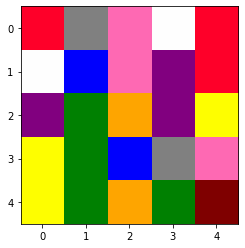

In [24]:
indices = np.random.randint(0, len(colors), size= (5,5))
plt.imshow(colors[indices]);

In [25]:
def create_mask_set(train_gen = train_gen):
    for images, masks in train_gen:
        new_lables = []
        for mask in masks:
            label, w, h = get_labels(mask, is_image_name=False)
            new_lables.append(label)
        yield(images, np.asarray(new_lables))

In [26]:
lab_gen = create_mask_set()
def plot_img2(ix):
    x, y = next(lab_gen)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].imshow(((x[0]).astype(np.uint8)))
    ax[0].set_title('Image')

    ax[1].imshow((get_image(y[0], w = y[0].shape[0], h = y[0].shape[1])))
    ax[1].set_title('mask');
    fig.show()



In [27]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    
    
    
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [28]:
mark = 15
file_name = 'model-unet-mark_{:03}.h5'.format(mark)

In [29]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [30]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=False)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    #EarlyStopping( patience=10, verbose=1),
    ReduceLROnPlateau( factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(file_name, verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(logdir, histogram_freq=1)
]